# Purpose of notebook: explore Citi Bike data

In [163]:
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import os
import matplotlib.pyplot as plt
import pickle
import datetime
import sqlalchemy
import imageio
import holidays
import warnings
data_path = './data'

# Connect to MySQL database that's holding station_count data. 
from external_variables import sql_un,sql_pwd
database_username = sql_un
database_password = sql_pwd
database_ip       = 'localhost'
database_name     = 'citi_bike'
conn_alchemy      = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                             format(database_username, database_password, 
                                                    database_ip, database_name)).connect()

# Develop a methodology for plotting on a map 

In [70]:
# Import streets for area of interest, save as ESRI shapefile. Then load. 

# The lines below (commented) can be used to download the street data. 
#north,south,east,west = 40.84,40.63,-73.865,-74.040
#G = ox.core.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True, retain_all=False, 
#                            truncate_by_edge=False)
#ox.save_load.save_graph_shapefile(G, filename='nyc_streets.shp', folder=data_path, encoding='utf-8')

nyc_streets = gpd.read_file(os.path.join(data_path,'nyc_streets.shp','edges','edges.shp'))
nyc_streets = nyc_streets.to_crs({'init': 'epsg:4326'})

In [17]:
# Create geodataframe to hold information on each docking station 
# (dock_id, name, coordinates)

def dock_dict_to_gdf(dock_dict): 
    """
    Function to create geodataframe with data in dock_dict. Obselete now that dock_dict 
    contents are in dock_info MySQL table. 
    """
    dock_ids,dock_name,dock_lat,dock_lon = [],[],[],[]
    for dock_id in dock_dict.keys():
        dock_ids.append(int(dock_id))
        dock_name.append(dock_dict[dock_id]['dock_name'])
        dock_lat.append(dock_dict[dock_id]['lat'])
        dock_lon.append(dock_dict[dock_id]['lon'])
    coords = list(zip(dock_lon, dock_lat))

    dock_df = pd.DataFrame({
        'dock_id': dock_ids,
        'dock_name': dock_name,
        'coords':coords
    })

    dock_df['coords'] = dock_df['coords'].apply(Point)
    dock_gdf = gpd.GeoDataFrame(dock_df,geometry='coords')
    dock_gdf.crs = {'init': 'epsg:4326'}
    
    return dock_gdf


def dock_info_to_gdf(conn_alchemy): 
    """
    Function to create geodataframe with data in dock_info. 
    
    INPUTS: 
    conn_alchemy = SQLAlchemy connection to citi_bike database. 
    
    OUTPUTS: 
    dock_gdf = geodataframe containing dock_id, dock_name, and coords for each dock
    
    dependencies: sqlalchemy, pandas, geopandas, shapely. 
    """
    # Select all data from dock_info table. 
    select_query = "SELECT * FROM dock_info;"
    raw_select = pd.read_sql(select_query, conn_alchemy, index_col=None)
    
    # Create geodataframe
    from shapely.geometry import Point
    coords = list(zip(raw_select['lon'], raw_select['lat']))
    dock_df = pd.DataFrame({
        'dock_id': raw_select['dock_id'],
        'dock_name': raw_select['dock_name'],
        'coords': coords
    })
    dock_df['coords'] = dock_df['coords'].apply(Point)
    dock_gdf = gpd.GeoDataFrame(dock_df,geometry='coords')
    dock_gdf.crs = {'init': 'epsg:4326'}
    
    return dock_gdf
    

from general_functions import save_pkl, load_pkl
dock_dict = load_pkl(os.path.join(data_path,'dock_dict.pkl'))
dock_gdf = dock_info_to_gdf(conn_alchemy)

Text(0.5, 1.0, 'Citi Bike stations in NYC')

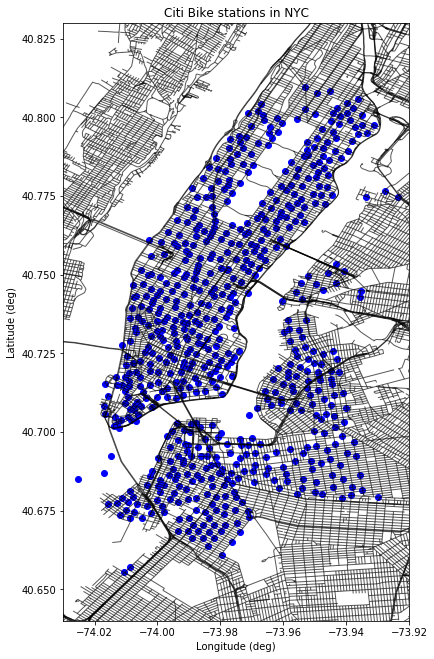

In [71]:
# Plot all stations on a map of NYC. 
def plot_nyc_base(ax,nyc_streets,time=None,street_alpha=0.35):
    """
    Function for plotting base of a map of NYC bike share data. 
    
    INPUTS: 
    ax = axis handle... for axes on which we want to plot a map. 
    nyc_streets = geodataframe for all streets in NYC. 
    time = Time for which we're plotting data. This will be printed in blue at the top of the map. 
    street_alpha = degree of transparency for streets. 0 = completely transparent. 
    
    OUTPUTS: ax
    ax = axis handle (same as entered)
    
    Dependencies: matplotlib, geopandas. 
    """
    nyc_streets.plot(ax=ax, color='k',linewidth=1,alpha=street_alpha)
    ax.set_xlim([-74.030, -73.92])
    ax.set_ylim([40.64, 40.83])
    ax.set_xlabel('Longitude (deg)')
    ax.set_ylabel('Latitude (deg)')
    if time is not None: 
        plt.text(-73.995,40.824,str(time),fontsize=22,alpha=1,color='b')
    return ax


size = 11
fig = plt.figure(figsize=[size,size])
ax = fig.add_subplot(111)
ax = plot_nyc_base(ax,nyc_streets,street_alpha=0.65)
dock_gdf.plot(ax=ax,color='b')
ax.set_title('Citi Bike stations in NYC')
#plt.close(fig)

In [ ]:
# Alternative: use folium.
#import folium
#dock_map = folium.Map(location=[40.73, -73.97], zoom_start=12, width=500, height=650)
#for _,row in dock_gdf.iterrows():
#    pt = [row['coords'].coords[:][0][1],row['coords'].coords[:][0][0]]
#    folium.Circle(location=pt,radius=2,color='blue',popup=str(row['dock_id'])).add_to(dock_map)#, popup=row['dock_id'], radius=1000, color='blue', fill=True, fill_color='blue').add_to(dock_map)
#dock_map

## 1. Animation (GIF) of frac_full for all stations over the course of a single day. 
Create two gifs: 
1. Plot fraction of each station that's full of bikes, at the beginning of each hour on a single day. 
2. Plot stations that are completely full/empty, at the beginning of each hour on a single day. Full stations are green, empty stations are red.

In [ ]:
# Some general functions. 
# Functions 
def filter_week_wknd_holi(dock_counts, week_wknd_holi):
    """
    This function takes in the dock_counts dataframe (aka. output from SQL query to dock_counts 
    database table) and information on whether we want to keep weekday, weekend, and holiday data, 
    and spits out the dataframe with all unwanted data removed. 
    
    dock_counts_rem = filter_week_wknd_holi(dock_counts, week_wknd_holi)
    
    dock_counts = dataframe, in form of direct output from SQL query to "dock_counts" database table
    week_wknd_holi = [week_bool,wknd_bool,holi_bool], where each indicates whether we want data 
                     from weekdays, weekends, or holidays. 
    dock_counts_rem = dock_counts with only data specified by week_wknd_holi. 
    """
    
    us_holidays = holidays.US(state='NY')
    dock_counts['holiday'] = [dt in us_holidays for dt in dock_counts['date_time']]
    dock_counts['weekend'] = [True if dt.weekday()>=5 else False for dt in dock_counts['date_time']] 

    if not week_wknd_holi[0]: # Keep days that are weekends, holidays, or both. 
        dock_counts = dock_counts[(dock_counts['weekend'] == 1) | (dock_counts['holiday'] == 1)]
    if not week_wknd_holi[1]: # Keep days that are weekdays, holidays, or both. 
        dock_counts = dock_counts[(dock_counts['weekend'] == 0) | (dock_counts['holiday'] == 1)]
    if not week_wknd_holi[2]: # Remove holidays
        dock_counts = dock_counts[(dock_counts['holiday'] == 0)]
        
    return dock_counts


def interpolate_frac_full(dock_counts,st_time,ed_time):
    """
    Interpolates frac_full column of dock_counts dataframe to the start of every hour between st_time and 
    ed_time, using nearest-neighbor interpolation. 
    
    interped_ff = interpolate_frac_full(dock_counts,st_time,ed_time)
    
    dock_counts = dataframe that has, at minimum, a "date_time" column and a "frac_full" column. 
    st_time = datetime corresponding to beginning of interval over which we want to interpolate the data. 
    ed_time = datetime corresponding to end of interval over which we want to interpolate the data.
    
    interped_ff = dataframe that contains the datetime, hours since 2000-01-01 00:00:00, and interpolated 
                  frac_full value, at the beginning of each hour from st_time to ed_time. 
    """
    # Prepare dataframe for interpolation. 
    base_time = pd.Timestamp(year=2000,month=1,day=1)
    time_delta = pd.Timedelta('1 hours')
    dock_counts['hours_2000'] = (dock_counts['date_time']-base_time)/time_delta

    # Prepare time vector for interpolation. 
    time_0 = round_to_hour(st_time)
    time_f = round_to_hour(ed_time)
    time_vec = pd.date_range(time_0, periods=(time_f-time_0)//pd.Timedelta('1 hours')+1, freq='H')
    time_vec_hours_2000 = (time_vec-base_time)/time_delta

    # Perform interpolation. 
    from scipy.interpolate import interp1d
    if len(dock_counts['frac_full'])>0: 
        interp_ff = interp1d(dock_counts['hours_2000'],dock_counts['frac_full'],kind='nearest',bounds_error=False)
        ff_time_vec = interp_ff(time_vec_hours_2000)

        # Set entry in interpolated vector = NaN. if not whithin 0.5 hrs of nearest observation (from database). 
        td_thresh = pd.Timedelta('30 minutes')
        for i,time in enumerate(time_vec): 
            ind_nearest = (np.abs(dock_counts['date_time']-time)).idxmin()
            nearest_time = dock_counts['date_time'].loc[ind_nearest]
            if np.abs(time-nearest_time)>td_thresh: 
                ff_time_vec[i] = np.NaN

    else: # If no data for dock...
        ff_time_vec = [np.NaN]*len(time_vec_hours_2000)
        
    interped_ff = pd.DataFrame({
        'date_time': time_vec,
        'hrs_2000': time_vec_hours_2000,
        'frac_full': ff_time_vec
    })
    
    return interped_ff

def centered_finite_diff(x,y):
    """
    Simple finite differencing scheme, which uses differences centered on the given time. 
    
    cdf_all = centered_finite_diff(x,y)
    
    x = independent variable for finite differencing. 
    y = dependent variable for finite differencing. 
    cdf_all = centered finite difference at each value of x. Unit: unit(y)/unit(x)
    
    """
    cfd_all = []
    for i,_ in enumerate(x):
        if i == 0: 
            cfd = (y[i+1]-y[i])/(x[i+1]-x[i])
        elif i == len(x)-1: 
            cfd = (y[i]-y[i-1])/(x[i]-x[i-1])
        else: 
            cfd = (y[i+1]-y[i-1])/(x[i+1]-x[i-1])
        cfd_all.append(cfd)
    return cfd_all


def round_to_hour(dt):
    """
    Function for rounding datetime to the nearest hour. 
    
    INPUT: 
    dt = datetime you want to round. 
    
    OUTPUT: rounded_dt
    rounded_dt = rounded datetime. 
    
    Dependencies: datetime
    """
    dt_start_of_hour = dt.replace(minute=0, second=0, microsecond=0)
    dt_half_hour = dt.replace(minute=30, second=0, microsecond=0)
    if dt >= dt_half_hour: # round up
        dt = dt_start_of_hour + datetime.timedelta(hours=1)
    else: # round down
        dt = dt_start_of_hour
    return dt


# Explore data: 

Things that might help understand the data: 
1. Animation (GIF) of frac_full for all stations over the course of a single day. 
2. What do time series of individual stations look like on weekdays, weekends, and holidays? In commercial areas, in residential areas, in places that don't typically show big variations? I'm thinking something like: time series of mean (solid black), 5th percentile, and 95th percentile for weekdays, weekends, and holidays for several different stations. 
3. What do the spatial patterns look like on weekdays, weekends, and holidays, typically?
4. How much time does each station spend completely empty or completely full? 
5. How can I weight the time empty/full by the distance to the nearest non-empty/full station? Use this as a new metric. 
6. How can I derive some measure of ACTIVITY at a specific station? Activity measure would be a function of the time of day. 

In [ ]:
def gif_for_day(conn_sql,day,dock_gdf,plot_nyc_base):
    """
    Function for creating: 
    1. Animation (GIF) of the fraction of each dock that's full, at the beginning 
    of each hour for a single day. 
    2. Animation (GIF) showing which stations are completely full or completely empty
    at the beginning of each hour for a single day. 
    
    INPUT: 
    conn_sql = SQLAlchemy connection to citi_bike database. 
    day = str(datetime) for day on which we want data. HH:MM:SS must be 00:00:00
    dock_gdf = geopandas geodataframe that contains the dock_id, dock_name, and coords for each 
               dock that you want plotted. 
    plot_nyc_base = function for plotting the basis for each map in the GIF -> streets, axis labels, 
                    the corresponding time. Must return figure and axis handles. 
    
    OUPUT: path_ff, path_fe
    path_ff = path/filename for gif of fraction full. 
    path_fe = path/filename for gif of full/empty. 
    
    Dependencies: pandas, os, geopandas, matplotlib, imageio, scipy
    
    """
    # Import interpolation function
    from scipy.interpolate import interp1d
    
    # Query the database: retrieve counts at all stations for a single day. 
    day_p1 = day+pd.Timedelta('1 days')
    sql_query = "SELECT * FROM dock_counts WHERE date_time >= '"+str(day)+"' AND date_time < '"+str(day_p1)+"'"
    daily_counts = pd.read_sql(sql_query,conn_alchemy,index_col='row_id',parse_dates=['date_time'])
    
    # If directory to save independent figs doesn't exist, create it! 
    #if not os.path.isdir('./figs/gifs'): 
    #    os.mkdir('./figs/gifs')
    
    # Plot fraction_full, empty, full at each dock, for each hour during a single day. 
    base_time = pd.Timestamp(year=2000,month=1,day=1)
    time_delta = pd.Timedelta('1 hours')
    times = pd.date_range(day, periods=24, freq='H')[1:]
    
    for time in times: 

        dock_frac_full = dock_gdf.copy()
        ff = []

        for _,row in dock_frac_full.iterrows():
            dock_id = row['dock_id']
            dc_dock = daily_counts[daily_counts['dock_id'] == dock_id].sort_values('date_time')

            if len(dc_dock.index) > 0: 

                dc_dock['frac_full'] = dc_dock['avail_bikes']/(dc_dock['avail_bikes']+dc_dock['avail_docks'])
                dc_dock['hours_2000'] = (dc_dock['date_time']-base_time)/time_delta

                interp_ff = interp1d(dc_dock['hours_2000'],dc_dock['frac_full'],kind='nearest',bounds_error=False)
                ff.append(float(interp_ff((time-base_time)/time_delta)))

            else: 
                ff.append(np.NaN)

        dock_frac_full['frac_full'] = ff

        # Plot fraction full and save. 
        frac_full = dock_frac_full[np.isnan(dock_frac_full['frac_full']) == 0]
        
        fig = plt.figure(figsize=[11,11])
        ax = fig.add_subplot(111)
        ax = plot_nyc_base(ax,nyc_streets,time)
        frac_full.plot(ax=ax,column='frac_full',markersize=40,cmap='RdYlGn',legend=True,alpha=1)
        time_str = datetime.datetime.strftime(time,'%Y_%m_%d_%H_%M_%S')
        fig.savefig(os.path.join('./figs','gifs','frac_full_'+time_str+'.jpg'), bbox_inches='tight')
        plt.close(fig)

        # Plot which docks are empty and full and save
        full_docks = dock_frac_full[dock_frac_full['frac_full'] == 1]
        empty_docks = dock_frac_full[dock_frac_full['frac_full'] == 0]
        
        fig = plt.figure(figsize=[11,11])
        ax = fig.add_subplot(111)
        ax = plot_nyc_base(ax,nyc_streets,time)
        full_docks.plot(ax=ax,color='g',markersize=40,alpha=1)
        empty_docks.plot(ax=ax,color='r',markersize=40,alpha=1)
        plt.text(-74.0275,40.650,'FULL',fontsize=22,alpha=1,color='g')
        plt.text(-74.0275,40.6425,'EMPTY',fontsize=22,alpha=1,color='r')
        fig.savefig(os.path.join('./figs','gifs','full_empty_'+time_str+'.jpg'), bbox_inches='tight')
        plt.close(fig)

    # Create gifs
    jpg_dir = './figs/gifs'
    kargs = { 'fps': 3, 'subrectangles':True }

    # frac_full gif
    images = []
    for file_name in sorted(os.listdir(jpg_dir)):
        if file_name.startswith('frac_full'):
            file_path = os.path.join(jpg_dir, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(os.path.join('./figs','frac_full.gif'), images, **kargs)

    # full_empty gif
    images = []
    for file_name in sorted(os.listdir(jpg_dir)):
        if file_name.startswith('full_empty'):
            file_path = os.path.join(jpg_dir, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(os.path.join('./figs','full_empty.gif'), images, **kargs)
    
    return os.path.join('./figs','frac_full.gif'),os.path.join('./figs','full_empty.gif')

day = pd.Timestamp(year=2018,month=5,day=3)
path_ff, path_fe = gif_for_day(conn_alchemy,day,dock_gdf)


## 2. What do time series at individual stations look like on weekdays, weekends, and holidays? 
For a single plot: create plots showing time series of the median, 5th percentile, and 95th percentile frac_full at each hour during the day, for weekends, weekdays, and holidays. Use all data available for thd dock in question. 

In [10]:
# Time series of individual stations -- averaged over entire time period. 
def dock_avg_timeseries(sql_conn,dock_id=72,query_st='2018-01-01 00:00:00',query_ed='2018-07-31 00:00:00',plot_ts=True):
    """
    Function for computing median, 5th percentile, and 95th percentile fraction_full for each station, as a 
    function of hour of day, based on all dock_counts for a given time interval. Also plots the median, 5th
    percentile, and 95th percentiles for weekdays, weekends, and holidays if switch for this is turned on. 
    
    INPUT: 
    sql_conn = SQLAlchemy connection to citi_bike database. 
    dock_id = ID of dock for which we want to plot the counts. 
    query_st = datetime at which the time interval starts. 
    query_ed = datetime at which the time interval ends. 
    plot_ts = switch for plotting median, 5th, and 95th percentiles. 
    
    OUTPUT: fig, ax, timeseries_df
    fig = figure handle for plot. None if plot_ts = False. 
    all_ax = list of axis handles for each axis on plot. None if plot_ts = False. 
    timeseries_df = dataframe that contains the median, 5th, and 95th percentile frac_full for weekdays, 
                    weekends, and holidays. Columns: hour, med_XXXX, p05_XXXX, and p95_XXXX, where XXXX 
                    is 'week', 'wknd', or 'holi'.
    
    Dependencies: round_to_hour (my function), pandas, numpy, holidays (library), matplotlib. 
    
    """
    
    # Query database: retrieve all counts for a given docking station. 
    sql_query = "SELECT row_id,date_time,avail_bikes,avail_docks,in_service,status_key FROM dock_counts "+ \
                "WHERE dock_id = "+str(dock_id)+" AND date_time >= '"+str(query_st)+"' AND date_time < '"+str(query_ed)+"';"
    dock_counts = pd.read_sql(sql_query,conn_alchemy,index_col='row_id',parse_dates=['date_time']).sort_values('date_time')
    
    # Filter out data from stations that are out of service. 
    dock_counts = dock_counts[(dock_counts['in_service']==1) & (dock_counts['status_key']==1)]
    
    # Interpolate fraction full to hourly time vector using nearest-neighbor interpolation. 
    dock_interp = interpolate_frac_full(dock_counts,query_st,query_ed)

    # Add some columns to interpolated df: date, day of week, weekend (T/F), holiday (T/F). 
    # Holidays module has most of the important holidays. 
    us_holidays = holidays.US(state='NY')
    day_of_week_key = ['Mo','Tu','We','Th','Fr','Sa','Su']
    dock_interp['day_of_week'] = [day_of_week_key[dt.weekday()] for dt in dock_interp['date_time']]
    dock_interp['holiday'] = [dt in us_holidays for dt in dock_interp['date_time']]
    dock_interp['weekend'] = [True if dt.weekday()>=5 else False for dt in dock_interp['date_time']] 
    
    # Now create some plots! 
    # Median, 5th, 95th percentiles at each hour for weekdays
    hours = [hr for hr in range(24)]
    med_week, p05_week, p95_week = [],[],[]
    for hr in hours: 
        obs = dock_interp['frac_full'][(dock_interp['weekend']==False) & (dock_interp['holiday']==False) & 
                                       (dock_interp['date_time'].apply(lambda x: x.hour == hr))]
        med_week.append(obs.median())
        p05_week.append(obs.quantile(q=0.05))
        p95_week.append(obs.quantile(q=0.95))

    # weekends
    med_wknd, p05_wknd, p95_wknd = [],[],[]
    for hr in hours: 
        obs = dock_interp['frac_full'][(dock_interp['weekend']==True) & 
                                       (dock_interp['date_time'].apply(lambda x: x.hour == hr))]
        med_wknd.append(obs.median())
        p05_wknd.append(obs.quantile(q=0.05))
        p95_wknd.append(obs.quantile(q=0.95))

    # and holidays
    med_holi, p05_holi, p95_holi = [],[],[]
    for hr in hours: 
        obs = dock_interp['frac_full'][(dock_interp['holiday']==True) & 
                                       (dock_interp['date_time'].apply(lambda x: x.hour == hr))]
        med_holi.append(obs.median())
        p05_holi.append(obs.quantile(q=0.05))
        p95_holi.append(obs.quantile(q=0.95))

    # Return dataframe with all these time series. 
    timeseries_df = pd.DataFrame({
        'hour': hours,
        'med_week': med_week, 
        'p05_week': p05_week, 
        'p95_week': p95_week, 
        'med_wknd': med_wknd, 
        'p05_wknd': p05_wknd, 
        'p95_wknd': p95_wknd, 
        'med_holi': med_holi, 
        'p05_holi': p05_holi, 
        'p95_holi': p95_holi
    })
        
    if plot_ts: 
        all_ax = []
        fig = plt.figure(figsize=[5,7.5])
        ax = fig.add_subplot(311)
        ax.plot(hours,med_week,'k-')
        ax.fill_between(hours,p05_week,p95_week,color='k',alpha=0.25)
        #ax.set_xlabel('Hour of day')
        ax.set_ylabel('Fraction full')
        ax.set_xlim([0,23])
        ax.set_ylim([0,1])
        ax.set_title('Dock ID = '+str(dock_id))
        plt.text(0.3,0.881,'Weekdays',fontsize=14,alpha=1,color='k')
        all_ax.append(ax)
        
        ax = fig.add_subplot(312)   
        ax.plot(hours,med_wknd,'k-')
        ax.fill_between(hours,p05_wknd,p95_wknd,color='k',alpha=0.25)
        #ax.set_xlabel('Hour of day')
        ax.set_ylabel('Fraction full')
        ax.set_xlim([0,23])
        ax.set_ylim([0,1])
        plt.text(0.3,0.881,'Weekends',fontsize=14,alpha=1,color='k')
        all_ax.append(ax)
        
        ax = fig.add_subplot(313)   
        ax.plot(hours,med_holi,'k-')
        ax.fill_between(hours,p05_holi,p95_holi,color='k',alpha=0.25)
        ax.set_xlabel('Hour of day')
        ax.set_ylabel('Fraction full')
        ax.set_xlim([0,23])
        ax.set_ylim([0,1])
        plt.text(0.3,0.881,'Holidays',fontsize=14,alpha=1,color='k')
        all_ax.append(ax)
    
        return fig,all_ax,timeseries_df
    
    else: 
        
        return None, None, timeseries_df

# Retrieve start and end of data in database. 
query_st = conn_alchemy.execute("SELECT min(date_time) FROM dock_counts;")
st_time = [a for a in query_st][0][0]
query_ed = conn_alchemy.execute("SELECT max(date_time) FROM dock_counts;")
ed_time = [a for a in query_ed][0][0]

dock_id = str(3002)
fig,ax,ts_df = dock_avg_timeseries(conn_alchemy,dock_id=dock_id,query_st=st_time,query_ed=ed_time,plot_ts=True)
fig.savefig(os.path.join('./figs','dock_ts','timeseries_fracfull_dockID_'+dock_id+'.jpg'), bbox_inches='tight')


## 3. Show spatial patterns for frac_full on weekdays, weekends, and holidays. 
Create three more gifs -- one showing median frac_full for weekdays, another for weekends, and a third for holidays. Save these in the ./figs directory. 

In [6]:
# Use function above to compute median time series for weekdays, weekends, and holidays for each station. 

def calc_or_retr_hrly_stats(sql_conn,dock_gdf,query_st,query_ed,data_path): 

    try: # If these have been calculated before, just read the data! 

        week_hrly_stats = pd.read_csv(os.path.join(data_path,'dock_week_hrly_stats.csv'))
        wknd_hrly_stats = pd.read_csv(os.path.join(data_path,'dock_wknd_hrly_stats.csv'))
        holi_hrly_stats = pd.read_csv(os.path.join(data_path,'dock_holi_hrly_stats.csv'))

    except: # If not, need to calculate everything and save! 

        week_hrly_stats = pd.DataFrame({'hour': list(range(23))})
        wknd_hrly_stats = pd.DataFrame({'hour': list(range(23))})
        holi_hrly_stats = pd.DataFrame({'hour': list(range(23))})

        for dock in dock_gdf['dock_id']:

            fig,ax,ts_df = dock_avg_timeseries(sql_conn,dock_id=dock,query_st=query_st,query_ed=query_ed,plot_ts=False)

            week_hrly_stats[str(dock)+'_med'] = ts_df['med_week']
            week_hrly_stats[str(dock)+'_p05'] = ts_df['p05_week']
            week_hrly_stats[str(dock)+'_p95'] = ts_df['p95_week']

            wknd_hrly_stats[str(dock)+'_med'] = ts_df['med_wknd']
            wknd_hrly_stats[str(dock)+'_p05'] = ts_df['p05_wknd']
            wknd_hrly_stats[str(dock)+'_p95'] = ts_df['p95_wknd']

            holi_hrly_stats[str(dock)+'_med'] = ts_df['med_holi']
            holi_hrly_stats[str(dock)+'_p05'] = ts_df['p05_holi']
            holi_hrly_stats[str(dock)+'_p95'] = ts_df['p95_holi']

            week_hrly_stats.to_csv(os.path.join(data_path,'dock_week_hrly_stats.csv'),index_label='hour')
            wknd_hrly_stats.to_csv(os.path.join(data_path,'dock_wknd_hrly_stats.csv'),index_label='hour')
            holi_hrly_stats.to_csv(os.path.join(data_path,'dock_holi_hrly_stats.csv'),index_label='hour')

    return week_hrly_stats,wknd_hrly_stats,wknd_hrly_stats

# Retrieve start and end of data in database. 
query_st = conn_alchemy.execute("SELECT min(date_time) FROM dock_counts;")
st_time = [a for a in query_st][0][0]
query_ed = conn_alchemy.execute("SELECT max(date_time) FROM dock_counts;")
ed_time = [a for a in query_ed][0][0]

week_hrly_stats,wknd_hrly_stats,wknd_hrly_stats = calc_or_retr_hrly_stats(sql_conn,dock_gdf,query_st,
                                                                          query_ed,data_path)



# Create gifs of median frac_full for each station, as function of hr of day. 
dfs = [week_hrly_stats,wknd_hrly_stats,holi_hrly_stats]
fnms = ['med_week_frac_full_','med_wknd_frac_full_','med_holi_frac_full_']
jpg_dir = './figs/gifs'

for fnm,hrly_stats in zip(fnms,dfs): 

    for hr in hrly_stats['hour']: 

        med_frac = []
        frac_full = dock_gdf.copy()

        for dock in frac_full['dock_id']:

            med_frac.append(hrly_stats[str(dock)+'_med'][(hrly_stats['hour'] == hr)].iloc[0])

        frac_full['med_frac'] = med_frac

        # Plot fraction full
        frac_full_plot = frac_full[np.isnan(frac_full['med_frac']) == 0]
        
        fig = plt.figure(figsize=[11,11])
        ax = fig.add_subplot(111)
        ax = plot_nyc_base(ax,nyc_streets,time='hour = '+(str(hr).rjust(2,'0')))
        frac_full_plot.plot(ax=ax,column='med_frac',markersize=40,cmap='RdYlGn',legend=True,alpha=1,vmin=0,vmax=1)
        time_str = 'hour_'+(str(hr).rjust(2,'0'))
        fig.savefig(os.path.join(jpg_dir,fnm+time_str+'.jpg'), bbox_inches='tight')
        plt.close(fig)
         
    # Create gif
    kargs = { 'fps': 3, 'subrectangles':True }
    images = []
    for file_name in sorted(os.listdir(jpg_dir)):
        if file_name.startswith(fnm):
            file_path = os.path.join(jpg_dir, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(os.path.join('./figs',fnm[:-1]+'.gif'), images, **kargs)


## 4. How much time does each station spend completely empty or full? 

In [84]:
# Create function to: compute time empty/full for a specific dock over a specific time interval. 

#def avg_hpd_empty_full(frac_full_vec,days_of_data):
#    hpd_empty = list(frac_full_vec).count(0)/days_of_data
#    hpd_full = list(frac_full_vec).count(1)/days_of_data
#    return hpd_empty, hpd_full

def calc_avg_hpd_empty_full(sql_conn,dock_id=72,st_time='2018-01-01 00:00:00',
                           ed_time='2018-07-31 23:59:59',week_wknd_holi = [True,False,False]): 
    """
    Function for calculating the average time a single dock spends empty/full every day (in hrs/day), 
    over a specific time interval. 
    
    time_empty, time_full days_of_data = calc_time_empty_full(sql_conn,metric_fcn,dock_id=72,
                        st_time='2018-01-01 00:00:00', ed_time='2018-07-31 23:59:59',
                        week_wknd_holi = [True,False,False])
    
    INPUTS: 
    sql_conn = SQLAlchemy connection to citi_bike database.  
    dock_id = dock ID for dock in question. 
    st_time = interval start time. Datetime or 'YYYY-mm-dd HH:MM:SS'
    st_time = interval end time. Datetime or 'YYYY-mm-dd HH:MM:SS'
    week_wknd_holi = List: [include_weekdays,include_weekends,include_holidays], where all entries are True
                     or False. Default is to only include weekdays.  
    
    OUTPUTS:
    time_empty = average hours/day the dock spent completely empty during that time period. 
    time_full = average hours/day the dock spent completely full during that time period. 
    days_of_data = Amount of data (in days) used to derive the time_empty and time_full values. 
                   Time the station spends out of service, time for which data isn't available, 
                   and time excluded by week_wknd_holi values are not included in days_of_data. 
    
    Dependencies: pandas, scipy (interp1d), numpy, holidays, round_to_hour (function I created). 
    """
    # Query database. 
    sql_query = "SELECT row_id,date_time,avail_bikes,avail_docks,in_service,status_key FROM dock_counts "+ \
                "WHERE dock_id = "+str(dock_id)+" AND date_time >= '"+str(st_time)+ \
                "' AND date_time < '"+str(ed_time)+"';"
    dock_counts = pd.read_sql(sql_query,sql_conn,index_col='row_id',parse_dates=['date_time']).sort_values('date_time')

    # Filter out data from stations that are out of service. 
    dock_counts = dock_counts[(dock_counts['in_service']==1) & (dock_counts['status_key']==1)]

    # Filter out values based on week_wknd_holi. 
    us_holidays = holidays.US(state='NY')
    dock_counts['holiday'] = [dt in us_holidays for dt in dock_counts['date_time']]
    dock_counts['weekend'] = [True if dt.weekday()>=5 else False for dt in dock_counts['date_time']] 
    
    if not week_wknd_holi[0]: # Keep days that are weekends, holidays, or both. 
        dock_counts = dock_counts[(dock_counts['weekend'] == 1) | (dock_counts['holiday'] == 1)]
    if not week_wknd_holi[1]: # Keep days that are weekdays, holidays, or both. 
        dock_counts = dock_counts[(dock_counts['weekend'] == 0) | (dock_counts['holiday'] == 1)]
    if not week_wknd_holi[2]: # Remove holidays
        dock_counts = dock_counts[(dock_counts['holiday'] == 0)]
    
    # Interpolate fraction full to hourly time vector using nearest-neighbor interpolation. 

    # Prepare dataframe for interpolation. 
    base_time = pd.Timestamp(year=2000,month=1,day=1)
    time_delta = pd.Timedelta('1 hours')
    dock_counts['frac_full'] = dock_counts['avail_bikes']/(dock_counts['avail_bikes']+dock_counts['avail_docks'])
    dock_counts['hours_2000'] = (dock_counts['date_time']-base_time)/time_delta

    # Prepare time vector for interpolation. 
    time_0 = round_to_hour(st_time)
    time_f = round_to_hour(ed_time)
    time_vec = pd.date_range(time_0, periods=(time_f-time_0)//pd.Timedelta('1 hours')+1, freq='H')
    time_vec_hours_2000 = (time_vec-base_time)/time_delta

    # Perform interpolation. 
    from scipy.interpolate import interp1d
    if len(dock_counts['frac_full'])>0: 
        interp_ff = interp1d(dock_counts['hours_2000'],dock_counts['frac_full'],kind='nearest',bounds_error=False)
        ff_time_vec = interp_ff(time_vec_hours_2000)
        
        # Set entry in interpolated vector = NaN. if not whithin 0.5 hrs of nearest observation (from database). 
        td_thresh = pd.Timedelta('30 minutes')
        for i,time in enumerate(time_vec): 
            ind_nearest = (np.abs(dock_counts['date_time']-time)).idxmin()
            nearest_time = dock_counts['date_time'].loc[ind_nearest]
            if np.abs(time-nearest_time)>td_thresh: 
                ff_time_vec[i] = np.NaN

        # Average hours empty and full, per day. Discount nan's in average. 
        hrs_no_data = list(np.isnan(ff_time_vec)).count(1)
        days_of_data = (time_f-time_0)/pd.Timedelta('1 days') - hrs_no_data/24
        hpd_empty = list(ff_time_vec).count(0)/days_of_data
        hpd_full = list(ff_time_vec).count(1)/days_of_data
        
    else: # If no data for dock...
        hpd_empty = np.NaN
        hpd_full = np.NaN
        days_of_data = 0
    
    return hpd_empty, hpd_full, days_of_data

dock_id   = dock_gdf['dock_id'].iloc[4]
st_time   = pd.Timestamp(year=2018,month=1,day=1,hour=0,minute=0,second=0)
ed_time   = pd.Timestamp(year=2018,month=7,day=31,hour=23,minute=59,second=59)
week_wknd_holi = [True,False,False]
he,hf,dod = calc_avg_hpd_empty_full(conn_alchemy,dock_id=dock_id,st_time=st_time,ed_time=ed_time,
                                week_wknd_holi=week_wknd_holi)
print(he,hf,dod)


nan nan 0


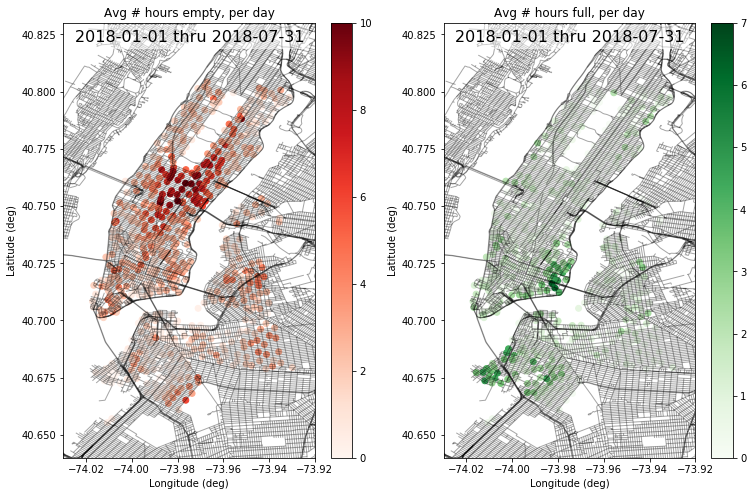

In [124]:
# Map of time spent empty (avg hrs/day), for each station over the chosen time interval. Table of rankings. 
# Map of time spent full (avg hrs/day), for each station over the chosen time interval. Table of rankings. 

def map_avg_hpd_empty_full(st_time,ed_time,week_wknd_holi,dock_gdf,calc_avg_hpd_empty_full,
                               nyc_streets,plot_nyc_base): 
    
    
    def create_filename(data_subject,st_time,ed_time,week_wknd_holi):
        str_st_time = datetime.datetime.strftime(pd.Timestamp(st_time),'%Y%m%d%H%M%S')
        str_ed_time = datetime.datetime.strftime(pd.Timestamp(ed_time),'%Y%m%d%H%M%S')
        tf_str = ''
        for tf in week_wknd_holi: 
            if tf: 
                tf_str = tf_str+'1'
            else: 
                tf_str = tf_str+'0'
        return data_subject+'_'+tf_str+'_'+str_st_time+'_'+str_ed_time+'.shp'
    
    # Name of file that stores each dock's evaluation score. 
    fname = create_filename(data_subject='avg_hrsperday_empty_full',st_time=st_time,ed_time=ed_time,
                            week_wknd_holi=week_wknd_holi)
    fpathname = os.path.join(data_path,'dock_scores',fname)

    try:      # Read this file if data is available. 
        dock_score = gpd.read_file(fpathname)
        dock_score['days_of_data'] = dock_score['days_of_da']
        dock_score = dock_score.drop('days_of_da',axis=1)
        
    except:   # If not, calculate the evaluation scores and save. 
        dock_score = dock_gdf.copy()
        hpd_empty,hpd_full,days_of_data = [],[],[]
        for dock_id in dock_score['dock_id']: 
            #print(dock_id)
            he,hf,dod = calc_avg_hpd_empty_full(conn_alchemy,dock_id=dock_id,st_time=st_time,ed_time=ed_time,
                                   week_wknd_holi=week_wknd_holi)
            # Having error above--calc_avg_hpd_empty_full fails when there isn't data for a given dock. 
            hpd_empty.append(he)
            hpd_full.append(hf)
            days_of_data.append(dod)

        dock_score['hpd_empty'] = hpd_empty
        dock_score['hpd_full'] = hpd_full
        dock_score['days_of_data'] = days_of_data

        dock_score.to_file(fpathname)
       
    if week_wknd_holi[0] and week_wknd_holi[1]:
        dod_thresh = 0.5*(ed_time-st_time)/pd.Timedelta('1 days')
    elif week_wknd_holi[0] and not week_wknd_holi[1]: 
        dod_thresh = 0.5*5/7*(ed_time-st_time)/pd.Timedelta('1 days')
    elif not week_wknd_holi[0] and week_wknd_holi[1]: 
        dod_thresh = 0.5*2/7*(ed_time-st_time)/pd.Timedelta('1 days')
    else: 
        dod_thresh = 1e-6
        
    data2plot = dock_score[(dock_score['days_of_data']>=dod_thresh)]
    
    ax_all = []
    fig = plt.figure(figsize=[12.5,8])
    ax = fig.add_subplot(121)
    plot_nyc_base(ax,nyc_streets)
    data2plot.plot(ax=ax,column='hpd_empty',markersize=35,cmap='Reds',legend=True,alpha=1,vmin=0,vmax=10)
    ax.set_title('Avg # hours empty, per day')
    ax_all.append(ax)
    ax = fig.add_subplot(122)
    plot_nyc_base(ax,nyc_streets)
    data2plot.plot(ax=ax,column='hpd_full',markersize=35,cmap='Greens',legend=True,alpha=1,vmin=0,vmax=7)
    ax.set_title('Avg # hours full, per day')
    ax_all.append(ax)
    
    return dock_score,fig,ax_all


st_time   = pd.Timestamp(year=2018,month=1,day=1,hour=0,minute=0,second=0)
ed_time   = pd.Timestamp(year=2018,month=7,day=31,hour=23,minute=59,second=59)

week_wknd_holi = [True,False,False]
dock_score,fig,ax = map_avg_hpd_empty_full(st_time,ed_time,week_wknd_holi,dock_gdf,calc_avg_hpd_empty_full,
                                               nyc_streets,plot_nyc_base)

ax[0].text(-74.025,40.822,str(st_time.date())+' thru '+str(ed_time.date()),
           fontsize=16,alpha=1,color='k',bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))
ax[1].text(-74.025,40.822,str(st_time.date())+' thru '+str(ed_time.date()),
           fontsize=16,alpha=1,color='k',bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))
fnm = 'avg_hpd_empty_full_'+str(st_time.date())+'_'+str(ed_time.date())+'.jpg'
fig.savefig(os.path.join('./figs',fnm), bbox_inches='tight')

#week_wknd_holi = [False,True,False]
#dock_score,fig,ax = map_avg_hpd_empty_full(st_time,ed_time,week_wknd_holi,dock_gdf,calc_avg_hpd_empty_full,
#                                               nyc_streets,plot_nyc_base)
#week_wknd_holi = [False,False,True]
#dock_score,fig,ax = map_avg_hpd_empty_full(st_time,ed_time,week_wknd_holi,dock_gdf,calc_avg_hpd_empty_full,
#                                               nyc_streets,plot_nyc_base)



## 5+6. Develop metric that takes activity and inconvenience into account. 
* If docks are empty when bikes are typically being removed, then it's a problem. 
* If docks are full when bikes are typically being added, then it's a problem. 
* For "activity" metric, can just use the rate of change in the median frac_full (this is easy because we've already computed the median frac_full for each hour at each station). 

In [216]:
# Figure out how to take activity into account. 

#query_st = conn_alchemy.execute("SELECT min(date_time) FROM dock_counts;")
#st_time = [a for a in query_st][0][0]
#query_ed = conn_alchemy.execute("SELECT max(date_time) FROM dock_counts;")
#ed_time = [a for a in query_ed][0][0]

week_wknd_holi = [True,False,False]
dock_id = dock_gdf['dock_id'].iloc[364]
st_time = pd.Timestamp(year=2018,month=1,day=1,hour=0,minute=0,second=0)
ed_time = pd.Timestamp(year=2018,month=7,day=31,hour=23,minute=59,second=59)
sql_conn = conn_alchemy

# Query database. 
sql_query = "SELECT row_id,date_time,avail_bikes,avail_docks,in_service,status_key FROM dock_counts "+ \
            "WHERE dock_id = "+str(dock_id)+" AND date_time >= '"+str(st_time)+ \
            "' AND date_time < '"+str(ed_time)+"';"
dock_counts = pd.read_sql(sql_query,sql_conn,index_col='row_id',parse_dates=['date_time']).sort_values('date_time')

# Filter out data from stations that are out of service. 
dock_counts = dock_counts[(dock_counts['in_service']==1) & (dock_counts['status_key']==1)]

# Filter out values based on week_wknd_holi. 
dock_counts = filter_week_wknd_holi(dock_counts, week_wknd_holi)

# Compute fraction full
dock_counts['frac_full'] = dock_counts['avail_bikes']/(dock_counts['avail_bikes']+dock_counts['avail_docks'])

# Interpolate fraction full to hourly time vector using nearest-neighbor interpolation. 
interped_ff = interpolate_frac_full(dock_counts,st_time,ed_time)


In [217]:
# Compute metric for "Activity"
# Average rate of bike removal
# Average rate of bike addition
interped_ff['hr_of_day'] = interped_ff['date_time'].apply(lambda x: x.hour)
        
interped_ff['roc_ff'] = centered_finite_diff(interped_ff['hrs_2000'],interped_ff['frac_full'])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interped_ff['roc_ff'][(interped_ff['frac_full']==0) | (interped_ff['frac_full']==1)] = np.NaN
    
#interped_ff['rate_rem'] = -interped_ff['roc_ff'][(interped_ff['roc_ff']<0)]
#interped_ff['rate_add'] = interped_ff['roc_ff'][(interped_ff['roc_ff']>0)]

hours = list(range(24))
avg_roc,avg_ff,med_ff = [],[],[]
for hour in hours: 
    #rate_rem.append(interped_ff['rate_rem'][(interped_ff['hr_of_day']==hour)].mean())
    #rate_add.append(interped_ff['rate_add'][(interped_ff['hr_of_day']==hour)].mean())
    avg_roc.append(interped_ff['roc_ff'][(interped_ff['hr_of_day']==hour)].mean())
    med_ff.append(interped_ff['frac_full'][(interped_ff['hr_of_day']==hour)].median())
    avg_ff.append(interped_ff['frac_full'][(interped_ff['hr_of_day']==hour)].mean())
    

(0, 23)

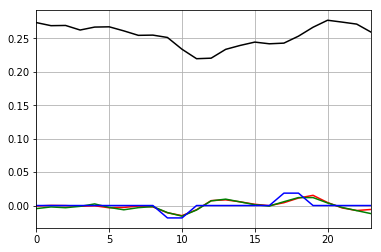

In [218]:
# Double check interpolation. 
#fig = plt.figure(figsize=[14,4])
#ax = fig.add_subplot(111)
#ax.plot(interped_ff['date_time'],interped_ff['date_time'].apply(lambda x: x.weekday())/7,'g-')
#ax.plot(dock_counts['date_time'],dock_counts['frac_full'],'k-')
#ax.plot(interped_ff['date_time'],interped_ff['frac_full'],'r-')
#ax.set_xlim(['2018-06-01','2018-07-31'])

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.plot(hours,avg_roc,'r-')
ax.plot(hours,avg_ff,'k-')
ax.plot(hours,centered_finite_diff(hours,avg_ff),'g-')
ax.plot(hours,centered_finite_diff(hours,med_ff),'b-')
ax.grid(True)
ax.set_xlim([0,23])





In [176]:
a = pd.DataFrame({'a':[1,np.nan,np.nan,15]})
a.mean()

a    8.0
dtype: float64

In [ ]:
# Close connection to MySQL database. 
conn_alchemy.close()